In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import plot_confusion_matrix, average_precission, custom_ap_scorer, sem_abrv_to_full

In [2]:
train_df = pd.read_csv("train_df.csv", index_col=0)
feature_names = train_df.columns.tolist()
feature_names.remove('label')
feature_names.remove('target')
X = train_df[feature_names].values
Y = train_df["target"].values

In [3]:
test_df = pd.read_csv("test_df.csv", index_col=0)
feature_names = test_df.columns.tolist()
feature_names.remove('label')
feature_names.remove('target')
X_test = test_df[feature_names].values
Y_test = test_df["target"].values

## Model Tuning

In [4]:
import warnings
warnings.filterwarnings('ignore')

penalty = ['elasticnet']
l1_ratio = np.linspace(0.0, 1.0, 10)
C = np.logspace(-3, 3, 20)
random_state=[2020]
solver=['saga']

hyperparameters = dict(C=C, penalty=penalty, l1_ratio=l1_ratio, solver=solver, random_state=random_state)

grid_search = GridSearchCV(LogisticRegression(), hyperparameters, cv=10, verbose=0, scoring='f1_micro')
start_time = time.time()
grid_search.fit(X, Y)
print("GridSearch took {:.1f} seconds".format(time.time() - start_time))

GridSearch took 106.5 seconds


In [5]:
print("Best parameters={}".format(grid_search.best_params_))
print("Best score={}".format(grid_search.best_score_))

Best parameters={'C': 26.366508987303554, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'random_state': 2020, 'solver': 'saga'}
Best score=0.7042229467473995


## Final Model

In [6]:
final_model = LogisticRegression(**grid_search.best_params_)
final_model.fit(X, Y)
Y_predict = final_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.69      0.43      0.53        21
           1       0.86      0.95      0.90        79

    accuracy                           0.84       100
   macro avg       0.78      0.69      0.72       100
weighted avg       0.83      0.84      0.83       100



Confusion matrix, without normalization


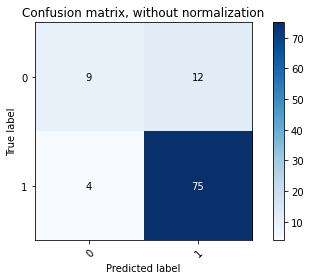

In [7]:
plot_confusion_matrix(Y_test, Y_predict, classes=[0, 1])

### Ranking

In [8]:
from sklearn.utils import shuffle

num_of_baseline_shuffles = 5
baseline_scores = []
for random_state in range(num_of_baseline_shuffles):
    temp = shuffle(Y_test, random_state=2020+num_of_baseline_shuffles*random_state)
    baseline_scores.append(average_precission(temp, 1))

print("Baseline Average Precission: {}".format(np.median(baseline_scores)))

Baseline Average Precission: 0.8193172135323005


In [9]:
Y_predict_prob = final_model.predict_proba(X_test)

In [10]:
rankings = {}
predict = {}
test_cuis = test_df.index.tolist()
for cui, probs in zip(test_cuis, Y_predict_prob):
    rankings[cui] = probs[1]
    if probs[1] > probs[0]:
        predict[cui] = 1
    else:
        predict[cui] = 0

predict_rank_labels = []
cui_order = {}
print(f"  # |    CUI   | {'Label':60} | Ranking | Predict/True")
print("-" * 110)
for ii, (cui, ranking) in enumerate(sorted(rankings.items(), key=lambda x: x[1], reverse=True), start=1):
    predict_rank_labels.append(test_df['target'][cui])
    cui_order[cui] = ii - 1
    print(f"{ii:3} | {cui} | {test_df['label'][cui]:60} | {ranking:.3f}   | {predict[cui]:7}/{test_df['target'][cui]:4}")

  # |    CUI   | Label                                                        | Ranking | Predict/True
--------------------------------------------------------------------------------------------------------------
  1 | C0072980 | Sirolimus                                                    | 0.996   |       1/   1
  2 | C0949860 | Isoprostanes                                                 | 0.993   |       1/   1
  3 | C0007134 | Renal Cell Carcinoma                                         | 0.993   |       1/   1
  4 | C0079870 | Mutagenesis, Site-Directed                                   | 0.992   |       1/   1
  5 | C0206630 | Endometrial Stromal Sarcoma                                  | 0.992   |       1/   1
  6 | C0222660 | Trabecular substance of bone                                 | 0.991   |       1/   1
  7 | C0075134 | Specific Substance of Maruyama                               | 0.986   |       1/   1
  8 | C1518406 | Non-Homologous DNA End-Joining                  

In [12]:
print("Average Precission: {}".format(custom_ap_scorer(Y_test, Y_predict_prob[:,1])))

Average Precission: 0.9243131323965222
